In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


# Importing Dataset

In [32]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets.squeeze()

In [33]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


# Splitting the data into training and testing subsets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing data using Pipeline

In [35]:
# Make sure y is 1-D on the split pieces (defensive)
y_train = np.ravel(y_train) if hasattr(y_train, "values") else y_train
y_test  = np.ravel(y_test)  if hasattr(y_test, "values")  else y_test

# Select numeric vs categorical columns from the training frame
num_cols = make_column_selector(dtype_include=np.number)(X_train)
cat_cols = make_column_selector(dtype_exclude=np.number)(X_train)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Build preprocessing: impute+scale for numeric, impute+one-hot for categorical
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


Numeric columns: ['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
Catego

# Defining a baseline model with DummyClassifier

In [36]:
baseline_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)


# Building and comparing Logistic Regression and k-NN
### Calculating table of Accuracy, Precision, Recall, and F1-score

In [37]:
def get_metrics(y_true, y_pred, average="macro"):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

knn = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

results = {
    "DummyClassifier": get_metrics(y_test, y_pred_baseline),
    "LogisticRegression": get_metrics(y_test, y_pred_logreg),
    "k-NN": get_metrics(y_test, y_pred_knn)
}
results_df = pd.DataFrame(results).T
print("\nModel Comparison without hyperparamters:")
print(results_df)


Model Comparison without hyperparamters:
                    accuracy  precision    recall        f1
DummyClassifier     0.499435   0.166478  0.333333  0.222055
LogisticRegression  0.768362   0.707005  0.675426  0.682601
k-NN                0.667797   0.580154  0.571895  0.573015


# Tuning hyperparameters

In [38]:
log_reg_params = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"],
    "clf__max_iter": [2000]
}
grid_log_reg = GridSearchCV(
    log_reg, log_reg_params,
    cv=5, scoring="accuracy", n_jobs=-1
)
grid_log_reg.fit(X_train, y_train)
best_log_reg = grid_log_reg.best_estimator_
print("\nBest Logistic Regression params:", grid_log_reg.best_params_)


knn_params = {
    "clf__n_neighbors": [3, 5, 7, 9, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
    # 1 = Manhattan, 2 = Euclidean
}
grid_knn = GridSearchCV(
    knn, knn_params,
    cv=5, scoring="accuracy", n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("\nBest KNN params:", grid_knn.best_params_)

y_pred_logreg_best = best_log_reg.predict(X_test)
y_pred_knn_best = best_knn.predict(X_test)




Best Logistic Regression params: {'clf__C': 1, 'clf__max_iter': 2000, 'clf__penalty': 'l2', 'clf__solver': 'saga'}

Best KNN params: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}


# Evaluating and interpreting results with metrics


Model Comparison with hyperparamters:
                          accuracy  precision    recall        f1
DummyClassifier           0.499435   0.166478  0.333333  0.222055
LogisticRegression        0.768362   0.707005  0.675426  0.682601
k-NN                      0.667797   0.580154  0.571895  0.573015
LogisticRegression_Tuned  0.768362   0.707005  0.675426  0.682601
k-NN_Tuned                0.708475   0.644966  0.589983  0.595246


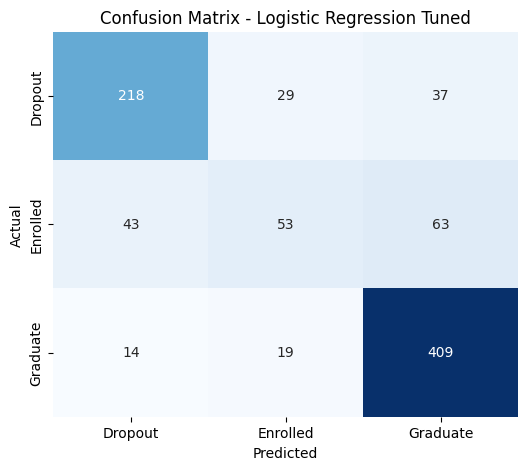

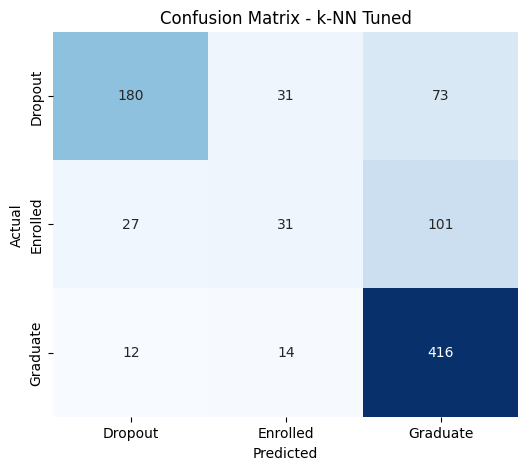

In [42]:
results["LogisticRegression_Tuned"] = get_metrics(y_test, y_pred_logreg_best)
results["k-NN_Tuned"] = get_metrics(y_test, y_pred_knn_best)
results_df = pd.DataFrame(results).T
print("\nModel Comparison with hyperparamters:")
print(results_df)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_logreg_best, "Confusion Matrix - Logistic Regression Tuned")
plot_confusion_matrix(y_test, y_pred_knn_best, "Confusion Matrix - k-NN Tuned")